Decided to use PyTorch. Keras was giving me quite a headache with it's abstractions.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io
import skimage.transform as sktrans

In [2]:
torch.cuda.get_device_name(torch.cuda.current_device())

'GeForce GTX 1070 Ti'

In [3]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

# All we care about at this point is the id and class
train_df = train_df.drop(["Unnamed: 0", "Unnamed: 0.1", "teethNumbers", "description", "numberOfCanals", "date", "sequenceNumber"], axis=1)
test_df = test_df.drop(["Unnamed: 0", "Unnamed: 0.1", "teethNumbers", "description", "numberOfCanals", "date", "sequenceNumber"], axis=1)

In [4]:
class LesionDataset(Dataset):
    """Teeth Lesion dataset."""
    
    def __init__(self, data_frame, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with image ids and labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.lesions_data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.lesions_data_frame)
    
    def __getitem__(self, idx):
        image_id = self.lesions_data_frame.iloc[idx].imageId
        image = io.imread(self.root_dir + image_id + '.jpg')
        image = sktrans.resize(image, (224, 224))
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        image = normalize(image)
        
        label = self.lesions_data_frame.iloc[idx].lesion
        label = label.astype('float')
        label = torch.from_numpy(np.array(label))
    
        return image, label

In [5]:
train_dataset = LesionDataset(
    train_df, "./lesion_images/all_images_processed/")
valid_dataset = LesionDataset(
    test_df, "./lesion_images/all_images_processed/")

torch.Size([3, 224, 224]) torch.Size([])
torch.float64 torch.float64


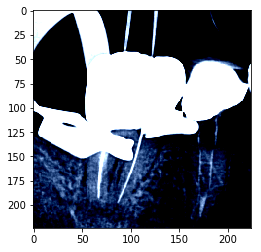

In [6]:
image, label = train_dataset[0]
print(image.size(), label.size())
print(image.dtype, label.dtype)

inp = image.numpy().transpose((1, 2, 0))
inp = np.clip(inp, 0, 1)
plt.imshow(inp)

In [7]:
train_dataloader = DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=4)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=4, shuffle=True, num_workers=4)

In [8]:
for i_batch, batch in enumerate(train_dataloader):
    images, labels = batch
    print(images.size(), labels.size())

    if i_batch == 0:
        break

torch.Size([4, 3, 224, 224]) torch.Size([4])


In [9]:
class Net(nn.Module):
    
    def __init__(self, num_classes):
        super(Net, self).__init__()
        
        self.densenet = models.densenet161(pretrained=True)
        
        # Swap last layer with our our classifier
        in_features = self.densenet.classifier.in_features
        out_features = 32 * 53 * 53
        self.densenet.classifier = nn.Linear(in_features, out_features)
        
#         self.conv1 = nn.Conv2d(1000, 16, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 53 * 53, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, num_classes)
        self.out = nn.Sigmoid()
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.densenet(x)
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(self.fc3(x))
        return x

In [10]:
classes = [0,1]
model = Net(len(classes))
model.cuda()

/home/jordan/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Net(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, tr

In [11]:
# Loss function
criterion = torch.nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.003, momentum= 0.9)

In [12]:

# number of epochs to train the model
n_epochs = 5 

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    running_loss = 0.0
    
    # train the model #
    model.train()
    for i_batch, batch in enumerate(train_dataloader):
        data, target = batch
        # move tensors to GPU if CUDA is available
        data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        # calculate the batch loss
        loss = criterion(output, target.long())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
        running_loss += loss.item()
        if i_batch % 20 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i_batch + 1, running_loss / 20))
            running_loss = 0.0
        
    # Validating the model
    model.eval()
    for i_batch, batch in enumerate(valid_dataloader):
        data, target = batch
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        # calculate the batch loss
        loss = criterion(output, target.long())
        # update average validation loss 
        valid_loss += loss.item() * data.size(0)
        
        running_loss += loss.item()
        if i_batch % 20 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch, i_batch, running_loss / 20))
            running_loss = 0.0
    
    # calculate average losses
    train_loss = train_loss/len(train_dataloader.dataset)
    valid_loss = valid_loss/len(valid_dataloader.dataset)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'pytorch_lesion_model.pt')
        valid_loss_min = valid_loss

[2,     1] loss: 0.035
[2,    21] loss: 0.697
[2,    41] loss: 0.699
[2,    61] loss: 0.696
[2,    81] loss: 0.693
[2,   101] loss: 0.688
[2,   121] loss: 0.693
[2,   141] loss: 0.687
[2,   161] loss: 0.671
[2,   181] loss: 0.710
[2,   201] loss: 0.690
[2,   221] loss: 0.695
[2,   241] loss: 0.694
[2,   261] loss: 0.689
[2,   281] loss: 0.685
[1,     0] loss: 0.097
[1,    20] loss: 0.684
[1,    40] loss: 0.696
[1,    60] loss: 0.689
[1,    80] loss: 0.690
Epoch: 1 	Training Loss: 0.691585 	Validation Loss: 0.689151
Validation loss decreased (inf --> 0.689151).  Saving model ...
[3,     1] loss: 0.032
[3,    21] loss: 0.673
[3,    41] loss: 0.685
[3,    61] loss: 0.682
[3,    81] loss: 0.672
[3,   101] loss: 0.640
[3,   121] loss: 0.645
[3,   141] loss: 0.645
[3,   161] loss: 0.666
[3,   181] loss: 0.588
[3,   201] loss: 0.594
[3,   221] loss: 0.591
[3,   241] loss: 0.614
[3,   261] loss: 0.588
[3,   281] loss: 0.603
[2,     0] loss: 0.087
[2,    20] loss: 0.665
[2,    40] loss: 0.641
[

In [ ]:
#nothing

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in valid_dataloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images.float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.long()).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 71 %


In [ ]:

train_loss = 0.0
train_loss/len(train_dataloader.dataset)

In [ ]:
data.size(0)

In [ ]:
loss.item()

In [ ]:
output

In [ ]:
import torchvision.models as models

class CNN_Model(nn.Module):
    
    def __init__(self, num_classes):
        super(CNN_Model, self).__init__()
        
        self.dataloader = dataloader
        
        self.densenet = models.densenet161(pretrained=True)
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        self.out_act = nn.Sigmoid()
        
    def forward(self, x):
        output = self.densenet(x)
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x1 = x.view(-1, 16 * 53 * 53)
        x1 = F.relu(self.fc1(x1))
        x1 = F.relu(self.fc2(x1))
        x1 = self.out_act(self.fc3(x1))
        
        return x1

    
class CNN:
    
    def __init__(self, dataloader, model):
        self.dataloader = dataloader
        self.criterion = nn.BCELoss()
        self.optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        self.model = model
        self.running_loss = 0.0
        self.num_epochs = 2
        
        self.register_hooks("conv2")
        
    def register_hooks(self, target_layer):
        print("Registering Hooks")
        
        def forward_hook(module, input_, output_):
            self._last_activation = output_

        def backward_hook(module, grad_in, grad_out):
            self._last_grad = grad_out[0]

        for layer_name, layer in self.model.named_modules():
            if layer_name == target_layer:
                layer.register_forward_hook(forward_hook)
                layer.register_backward_hook(backward_hook)
                print("Hooks Regsitered for layer: ", target_layer)
                break
    
    def train(self):
        print('Starting Training')
        for epoch in range(self.num_epochs):  # loop over the dataset multiple times
            for batch_idx, data in enumerate(self.dataloader, 0):
                # get the inputs
                inputs, labels = data

                # zero the parameter gradients
                self.optimizer.zero_grad()

                classification, class_loss, attention_map = self.forward(inputs, labels)
                
                class_loss.backward()
                self.optimizer.step()

                # print statistics 
                if batch_idx % 20 == 0:    # print every 20 mini-batches
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(dataloader.dataset),
                        100. * batch_idx / len(dataloader), class_loss.item()))

        print('Finished Training')
    
    def forward(self, inputs, labels):
        # forward + backward + optimize
        classification = self.model(inputs)
        
        float_labels = labels.float()
        
        # Need to do this so that self._last_grad will be set.
        grad_target = (classification * float_labels).sum()
        grad_target.backward(gradient=float_labels * classification, retain_graph=True)
        
        self.model.zero_grad()

        # attention map stuff?
        # Eq 1
        class_weights = F.avg_pool2d(
            self._last_grad, 
            (self._last_grad.shape[-2], self._last_grad.shape[-1]),
            1)
        class_weights_new_shape = (
            class_weights.shape[0] * class_weights.shape[1], 
            class_weights.shape[2], class_weights.shape[3])
        class_weights_reshaped = class_weights.view(class_weights_new_shape).unsqueeze(0)
        

        # Eq 2
        weights = self._last_activation
        weights_new_shape = (weights.shape[0] * weights.shape[1], weights.shape[2], weights.shape[3])
        weights_reshaped = weights.view(weights_new_shape).unsqueeze(0)

        grad_cam = F.relu(F.conv2d(weights_reshaped, class_weights_reshaped))
        attention_map = F.upsample(grad_cam, size=inputs.size()[2:], mode='bilinear')
        
        class_loss = self.criterion(classification, float_labels)
        
        return classification, class_loss, attention_map
    
    def predict(self, validation_set):
        testloader = DataLoader(validation_set, batch_size=4,
                        shuffle=True, num_workers=4)

        correct1 = 0
#         correct2 = 0
        total = 0

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                out1 = self.model(images)
#                 out1, out2 = net(images)
                _, predicted1 = torch.max(out1.data, 1)
#                 _, predicted2 = torch.max(out2.data, 1)
                total += labels.size(0)
                correct1 += (predicted1 == labels).sum().item()
#                 correct2 += (predicted2 == labels).sum().item()

        print('Accuracy of the network on the test images: %d %%' % (100 * correct1 / total))
#         print('Accuracy of the network on the test images: %d %%' % (100 * correct2 / total))

In [ ]:
cnn_model = CNN_Model(1)
cnn = CNN(dataloader, cnn_model)

In [ ]:
cnn.train()

In [ ]:
cnn.predict(validation_set)

In [ ]:
# Attention map output test

for i_batch, sample_batched in enumerate(dataloader):
    images, labels = sample_batched
    
    classification, class_loss, attention_map = cnn.forward(images, labels)
    break
    

In [ ]:
flat_heatmap = attention_map[0].detach().numpy().flatten()
print(flat_heatmap.shape)
np.max(flat_heatmap)
# np.true_divide(flat_heatmap, np.max(flat_heatmap))
# heatmap = attention_map[0].permute(1, 2, 0).detach().numpy()
# flat_heatmap = heatmap.flatten()

# heatmap = np.true_divide(heatmap, np.max(heatmap))
# heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
# print(heatmap.shape)
# plt.imshow(heatmap)


I think what I need to do, is to create an initial classification model to load into the Attention Map class. From there I can define a new forward pass that will use the classification output of that model.

I can also define the layer names in that model and use the register hooks function to apply a backward hook to the last conv layer

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

In [ ]:
for idx, m in net.named_modules():
    print("index: ", idx)
    print("layer: ", m)